In [35]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import matplotlib.pyplot as plt

#parameters initialization
d_model = 256  # Embedding Size
d_ff = 2048 # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

sentences = [
        # enc_input           dec_input         dec_output
        ['ich mochte ein panzer P', 'S i want a tank .', 'i want a tank . E'],
        ['ich mochte ein cola P', 'S i want a coke .', 'i want a coke . E']
]

src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'panzer' : 4, 'cola' : 5}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'tank' : 4, 'coke' : 5, 'S' : 6, 'E' : 7, '.' : 8}
idx2word = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5
tgt_len = 6

def make_data(sentences):
    enc_inputs, dec_inputs, dec_outputs = [], [], []
    for i in range(len(sentences)):
      enc_input = [[src_vocab[n] for n in sentences[i][0].split()]]
      dec_input = [[tgt_vocab[n] for n in sentences[i][1].split()]]
      dec_output = [[tgt_vocab[n] for n in sentences[i][2].split()]]
      enc_inputs.extend(enc_input)
      dec_inputs.extend(dec_input)
      dec_outputs.extend(dec_output)

    return torch.LongTensor(enc_inputs), torch.LongTensor(dec_inputs), torch.LongTensor(dec_outputs)

enc_inputs, dec_inputs, dec_outputs = make_data(sentences)

class MyDataSet(Data.Dataset):
  def __init__(self, enc_inputs, dec_inputs, dec_outputs):
    super(MyDataSet, self).__init__()
    self.enc_inputs = enc_inputs
    self.dec_inputs = dec_inputs
    self.dec_outputs = dec_outputs

  def __len__(self):
    return self.enc_inputs.shape[0]

  def __getitem__(self, idx):
    return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]

loader = Data.DataLoader(MyDataSet(enc_inputs, dec_inputs, dec_outputs), 2, True)

In [36]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [37]:
#Attention masks, both Encoder and Decoder
def get_attn_pad_mask(seq_q, seq_k):
    '''
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
    return pad_attn_mask.expand(batch_size, len_q, len_k)


def get_attn_subsequence_mask(seq):
    '''
    seq: [batch_size, tgt_len]
    '''
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask

In [38]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        scores.masked_fill_(attn_mask, -1e9)

        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,2)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)


        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v)
        output = self.fc(context) # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model).cuda()(output + residual), attn

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual) # [batch_size, seq_len, d_model]

In [39]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        '''
        enc_outputs = self.src_emb(enc_inputs)
        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1)
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

In [40]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):

        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)

        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        enc_intpus: [batch_size, src_len]
        enc_outputs: [batch_size, src_len, d_model]
        '''
        dec_outputs = self.tgt_emb(dec_inputs)
        dec_outputs = self.pos_emb(dec_outputs.transpose(0, 1)).transpose(0, 1).cuda()
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).cuda()
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).cuda()
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0).cuda()

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs)
dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0)

In [41]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder().cuda()
        self.decoder = Decoder().cuda()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False).cuda()
    def forward(self, enc_inputs, dec_inputs):

        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs)
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

# Optimizer
model = Transformer().cuda()
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

In [42]:
Num_epoch=100
Losses=np.zeros(Num_epoch)
for epoch in range(Num_epoch):
    for enc_inputs, dec_inputs, dec_outputs in loader:
      '''
      enc_inputs: [batch_size, src_len]
      dec_inputs: [batch_size, tgt_len]
      dec_outputs: [batch_size, tgt_len]
      '''
      enc_inputs, dec_inputs, dec_outputs = enc_inputs.cuda(), dec_inputs.cuda(), dec_outputs.cuda()
      outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
      loss = criterion(outputs, dec_outputs.view(-1))
      Losses[epoch] = loss
      print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

Epoch: 0001 loss = 2.224779
Epoch: 0002 loss = 2.193844
Epoch: 0003 loss = 1.983824
Epoch: 0004 loss = 1.918685
Epoch: 0005 loss = 1.685724
Epoch: 0006 loss = 1.501424
Epoch: 0007 loss = 1.302533
Epoch: 0008 loss = 1.235084
Epoch: 0009 loss = 0.961154
Epoch: 0010 loss = 0.812511
Epoch: 0011 loss = 0.643967
Epoch: 0012 loss = 0.498507
Epoch: 0013 loss = 0.423318
Epoch: 0014 loss = 0.345736
Epoch: 0015 loss = 0.254674
Epoch: 0016 loss = 0.239817
Epoch: 0017 loss = 0.161808
Epoch: 0018 loss = 0.152206
Epoch: 0019 loss = 0.133579
Epoch: 0020 loss = 0.103951
Epoch: 0021 loss = 0.108990
Epoch: 0022 loss = 0.089564
Epoch: 0023 loss = 0.076183
Epoch: 0024 loss = 0.075170
Epoch: 0025 loss = 0.055653
Epoch: 0026 loss = 0.051555
Epoch: 0027 loss = 0.069240
Epoch: 0028 loss = 0.045048
Epoch: 0029 loss = 0.065447
Epoch: 0030 loss = 0.050524
Epoch: 0031 loss = 0.042165
Epoch: 0032 loss = 0.042777
Epoch: 0033 loss = 0.041708
Epoch: 0034 loss = 0.028529
Epoch: 0035 loss = 0.029169
Epoch: 0036 loss = 0

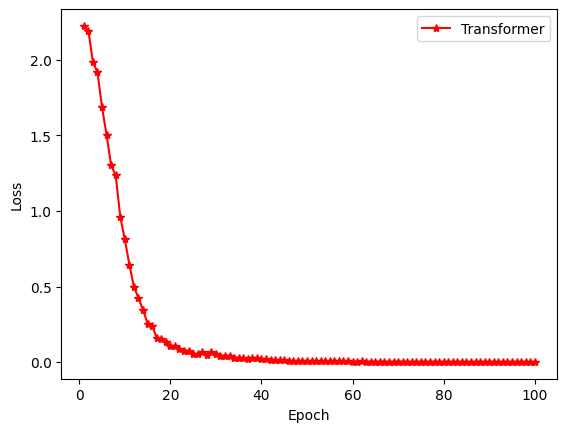

In [43]:
epoches=np.arange(Num_epoch)+1

plt.plot(epoches,Losses,'r*-',label='Transformer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
def greedy_decoder(model, enc_input, start_symbol):

    enc_outputs, enc_self_attns = model.encoder(enc_input)
    dec_input = torch.zeros(1, 0).type_as(enc_input.data)
    terminal = False
    next_symbol = start_symbol
    while not terminal:
        dec_input = torch.cat([dec_input.detach(),torch.tensor([[next_symbol]],dtype=enc_input.dtype).cuda()],-1)
        dec_outputs, _, _ = model.decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[-1]
        next_symbol = next_word
        if next_symbol == tgt_vocab["."]:
            terminal = True
        print(next_word)
    return dec_input

#Evaluation
enc_inputs, _, _ = next(iter(loader))
enc_inputs = enc_inputs.cuda()
for i in range(len(enc_inputs)):
    greedy_dec_input = greedy_decoder(model, enc_inputs[i].view(1, -1), start_symbol=tgt_vocab["S"])
    predict, _, _, _ = model(enc_inputs[i].view(1, -1), greedy_dec_input)
    predict = predict.data.max(1, keepdim=True)[1]
    print(enc_inputs[i], '->', [idx2word[n.item()] for n in predict.squeeze()])

tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(5, device='cuda:0')
tensor(8, device='cuda:0')
tensor([1, 2, 3, 5, 0], device='cuda:0') -> ['i', 'want', 'a', 'coke', '.']
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(8, device='cuda:0')
tensor([1, 2, 3, 4, 0], device='cuda:0') -> ['i', 'want', 'a', 'tank', '.']
